In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.gridspec as gridspec
import pymc as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pylab as pl
import scipy as sp
import pymc.graph
from graphviz import Digraph
import pydot
from IPython.display import Image

Couldn't import dot_parser, loading of dot files will not be possible.


In [9]:
N = 1
total_int_calls_minutes = pm.HalfNormal("total_int_calls_minutes", tau=1.0/10000, size=N)
# intl_calls_price_per_min = pm.Lognormal("intl_calls_price_per_min",mu=0.0, tau=10.0, size=N)

no_pack_ppm = 1.3
intl_pack_list = [(0,'no_pack',0,no_pack_ppm), (1,'pack50',50,1), (2,'pack150',150,0.8), (3,'pack225',225,0.6), (4,'pack400',400,0.4)]
intl_pack_labels = map(lambda p: p[1],intl_pack_list)

# init_pack_dist = [.2, .2, .2, .2, .2]
init_pack_dist = [.4, .15, .15, .15, .15]
intl_pack_id = pm.Categorical("intl_pack_id",init_pack_dist, size=N)

def get_act_price(total_min, pack_min, pack_ppm):
    pack_charge = pack_min*pack_ppm
    over_pack_charge = max(0,total_min - pack_min)*no_pack_ppm
    act_price = (pack_charge+over_pack_charge)/max(1,total_min) 
    return act_price

price_complaints_number_before = pm.Lambda('price_complaints_number_before', \
                                           lambda total_min=total_int_calls_minutes, \
                                                   curr_pack_id=intl_pack_id,  \
                                                   pack_list=intl_pack_list:\
                                           round(max(0.01,np.log(get_act_price(total_min, intl_pack_list[curr_pack_id][2], intl_pack_list[curr_pack_id][3])*50/5))))

is_offered = pm.Bernoulli("is_offered", p=0.5, size=N)

@pm.deterministic
def package_offer(offer=is_offered, total_min=total_int_calls_minutes, curr_pack_id=intl_pack_id, pack_list=intl_pack_list):    
    curr_pack = pack_list[curr_pack_id]    
    if(offer):
        packs_calc = map(lambda pack: (pack, get_act_price(total_min, pack[2], pack[3])),pack_list)
        curr_pack = min(packs_calc, key = lambda x: x[1])[0]        
    return curr_pack

@pm.deterministic
def intl_actual_price_per_min(curr_pack=package_offer, total_min=total_int_calls_minutes, pack_list=intl_pack_list):
    real_price_ratio = get_act_price(total_min, curr_pack[2], curr_pack[3])
    return real_price_ratio


price_complaints_number_after = pm.Lambda('price_complaints_number_after', lambda t=intl_actual_price_per_min:  round(max(0.01,np.log(t*50/5))))

    
# churn_p = pm.Lambda('churn_p', lambda nc=price_complaints_number_after: 1.0-np.exp(-nc/2))
churn_p = pm.Lambda('churn_p', lambda nc=price_complaints_number_after: 1/(1+np.exp(7-2*nc)))
is_churn = pm.Bernoulli("is_churn",churn_p,size=N) 

    

    
    
        


In [10]:
model = pm.Model([total_int_calls_minutes,
#                   intl_calls_price_per_min,
#                   intl_pack_list,
                  intl_pack_id,
                  price_complaints_number_before,
                  is_offered,
                  package_offer,                  
                  intl_actual_price_per_min,
                  price_complaints_number_after,
                  churn_p,
                  is_churn
                 ])

mcmc = pm.MCMC(model)
mcmc.sample(20000,500)

 [-----------------100%-----------------] 20000 of 20000 complete in 5.8 sec

In [11]:
init_pack = mcmc.trace('intl_pack_id')[:,0]
offered = mcmc.trace('is_offered')[:,0]
calls_minutes = mcmc.trace('total_int_calls_minutes')[:,0]
act_ppm = mcmc.trace('intl_actual_price_per_min')[:]
complaints_before = mcmc.trace('price_complaints_number_before')[:]
complaints_after = mcmc.trace('price_complaints_number_after')[:]
pack_offer = mcmc.trace('package_offer')[:,0]
churn_p =mcmc.trace('churn_p')[:]
churn =mcmc.trace('is_churn')[:,0]


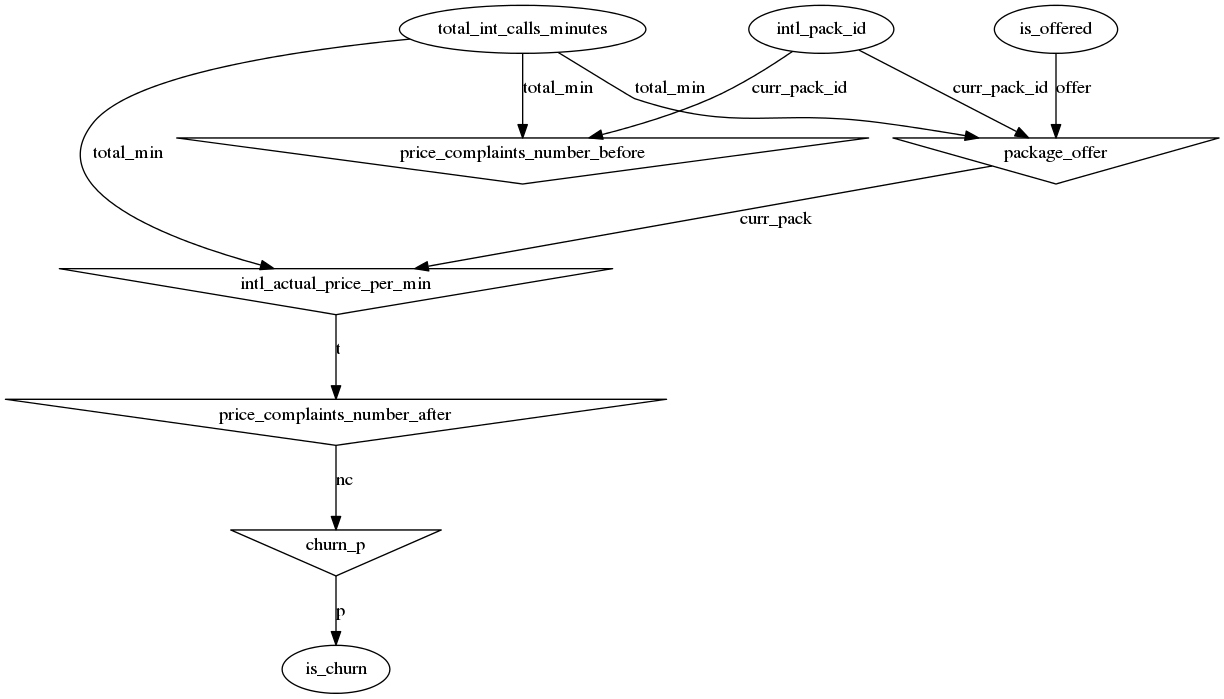

In [12]:
%matplotlib inline

xx = pymc.graph.dag(model)
xx.write_png('guy_graph.png', prog='dot')

Image('guy_graph.png')


In [13]:
calls_minutes

array([ 130.3950072 ,   43.57431466,  204.166356  , ...,   10.83640425,
        112.15704581,  171.06993464])

In [14]:
mcmc.write_csv('./nba_datagen2.csv',variables=['intl_pack_id','is_offered','total_int_calls_minutes','intl_actual_price_per_min'])

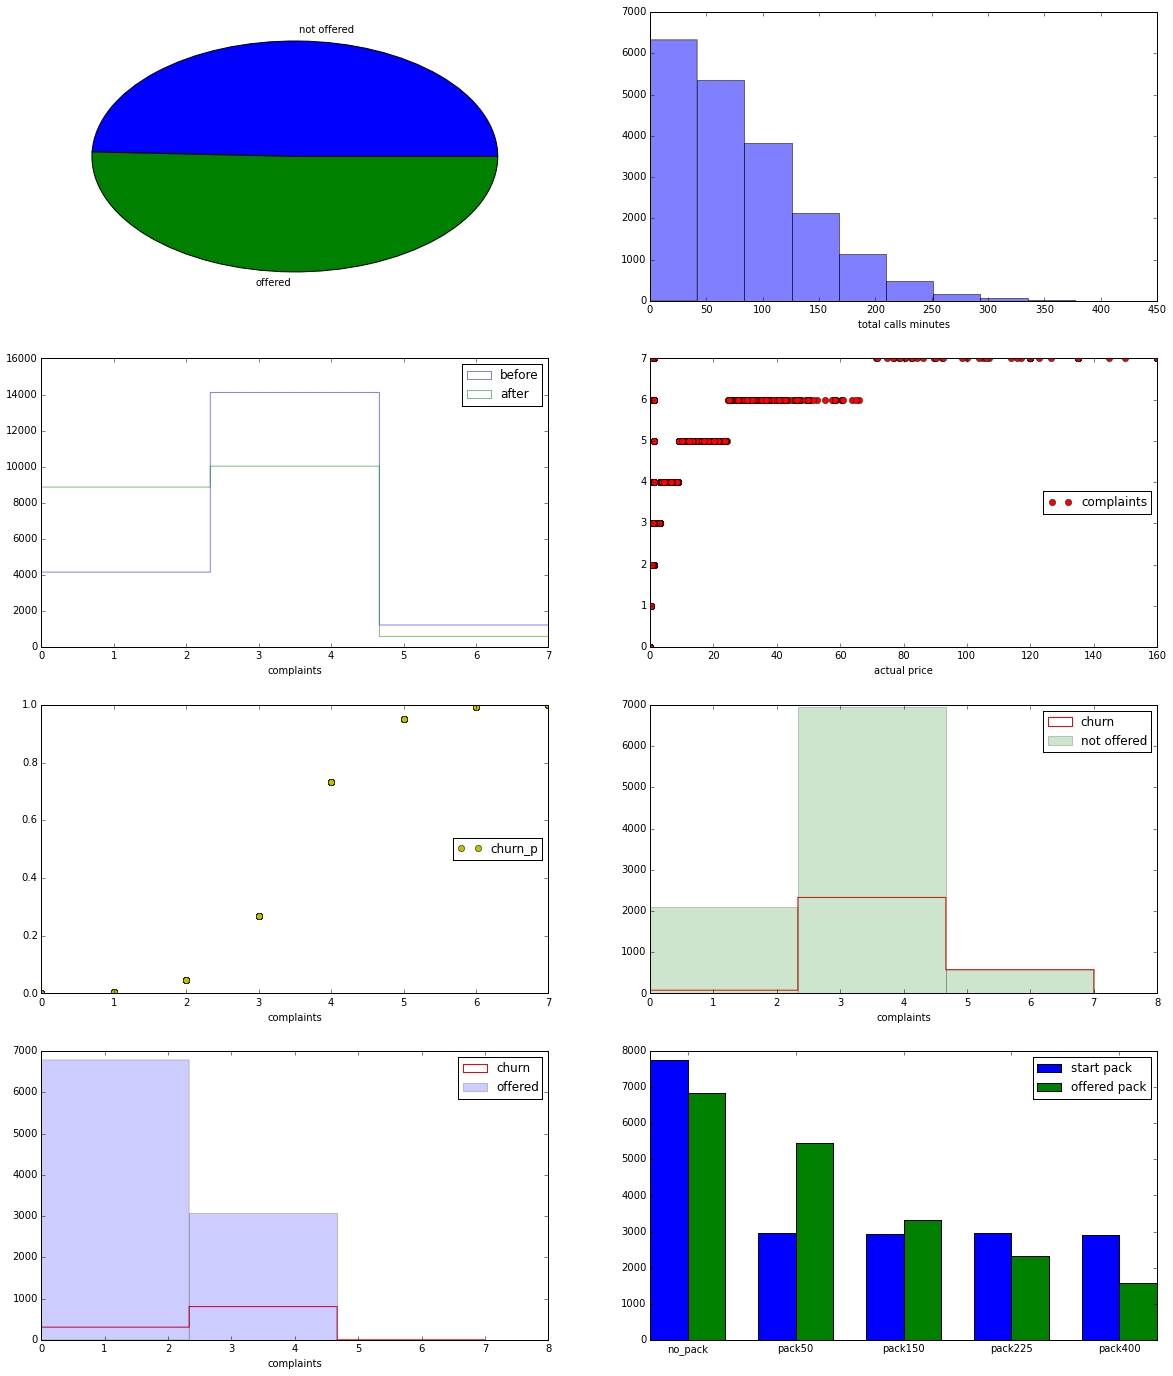

In [15]:
# {'bar', 'barstacked', 'step',  'stepfilled'}
figsize(20,30)
NN=5000
rows = 5
cols =2
i = range(1,cols*rows)
i.reverse()

complaints_bins = np.linspace(0, max(complaints_after),4)


plt.subplot(rows, cols,i.pop())
plt.pie(np.histogram(offered, bins=2)[0], labels=['not offered', 'offered'])


# plt.subplot(rows,cols,i.pop())
# plt.hist(complaints_before[~offered], bins=complaints_bins, alpha=0.5, label='not offered',histtype='bar')
# plt.hist(complaints_before[offered], bins=complaints_bins, alpha=0.5, label='offered', histtype='bar')
# plt.xlabel("complaints before")
# plt.legend(loc='upper right')


plt.subplot(rows,cols,i.pop())
plt.hist(calls_minutes, bins=10, alpha=0.5, label='count',histtype='bar')
plt.xlabel('total calls minutes')


plt.subplot(rows,cols,i.pop())
plt.hist(complaints_before, bins=complaints_bins, alpha=0.5, label='before',histtype='step')
plt.hist(complaints_after, bins=complaints_bins, alpha=0.5, label='after', histtype='step')
plt.xlabel("complaints")
plt.legend(loc='upper right')


plt.subplot(rows,cols,i.pop())
plt.plot(act_ppm, complaints_before, 'or',label='complaints')
plt.xlabel("actual price")
plt.legend(loc='right')


plt.subplot(rows,cols,i.pop())
plt.plot(complaints_after, churn_p, 'oy',label='churn_p')
plt.xlabel("complaints")
plt.legend(loc='right')

# plt.subplot(rows,cols,i.pop())
# plt.hist(complaints_after[~offered], bins=complaints_bins, alpha=0.5, label='not offered',histtype='bar')
# plt.hist(complaints_after[offered], bins=complaints_bins, alpha=0.5, label='offered', histtype='bar')
# plt.xlabel("complaints after")
# plt.legend(loc='upper right')



# ax1 = plt.subplot(rows,cols,i.pop())
# h1=ax1.hist(complaints_after[churn], bins=complaints_bins, alpha=0.5, label='churn', histtype='bar', color='red')
# h2=ax1.hist(complaints_after[~churn], bins=complaints_bins, alpha=0.5, label='not churn',histtype='bar')
# ax1.set_xlabel("complaints")
# ax1.legend(loc='upper right')
# ax2 = ax1.twinx()
# l1=ax2.plot(complaints_after, churn_p, '.r',label='churn_p')
# ax2.set_ylabel('churn_p')
# ax2.legend(loc='right')





plt.subplot(rows,cols,i.pop())
plt.hist(complaints_after[churn & ~offered], bins=complaints_bins, alpha=1, label='churn', histtype='step', color='red')
plt.hist(complaints_after[~offered], bins=complaints_bins, alpha=0.2, label='not offered',histtype='bar', color='green')
plt.xlabel("complaints")
plt.legend(loc='upper right')


plt.subplot(rows,cols,i.pop())
plt.hist(complaints_after[churn & offered], bins=complaints_bins, alpha=1, label='churn', histtype='step', color='red')
plt.hist(complaints_after[offered], bins=complaints_bins, alpha=0.2, label='offered',histtype='bar')
plt.xlabel("complaints")
plt.legend(loc='upper right')




plt.subplot(rows,cols,i.pop())
index = np.arange(len(intl_pack_labels))
bar_width = 0.35
plt.xticks(index + bar_width, intl_pack_labels)
plt.bar(index, sp.stats.itemfreq(init_pack)[:,1].astype(int),bar_width,label='start pack')
plt.bar(index+bar_width, sp.stats.itemfreq(pack_offer)[:,1].astype(int),bar_width,label='offered pack',color='g')
plt.legend(loc='upper right')

# plt.subplot(rows,cols,i.pop())
# plt.hist(pack_offer,50,label='after pack')
# plt.legend(loc='lower right')



In [23]:
total_min=100


packs_calc = map(lambda pack: (pack, get_act_price(total_min, pack[2], pack[3])),intl_pack_list)
print packs_calc
min(packs_calc, key = lambda x: x[1])[0]

[((0, 'no_pack', 0, 1.5), 1.5), ((1, 'pack50', 50, 1), 1.25), ((2, 'pack150', 150, 0.8), 1.2), ((3, 'pack225', 225, 0.6), 1.35), ((4, 'pack400', 400, 0.4), 1.6)]


(2, 'pack150', 150, 0.8)

In [196]:
# plt.subplot(rows,cols,i.pop())
# complaints_bins = np.linspace(0, max(complaints_after),4)
# compl__not_off = np.histogram(complaints_after[~offered], bins=complaints_bins)
# compl__off = np.histogram(complaints_after[offered], bins=complaints_bins)
# plt.bar(compl__not_off[1][compl__not_off[1]>0], compl__not_off[0], color='y')
# plt.bar(compl__off[1][compl__off[1]>0], compl__off[0], color='g')
# plt.xlabel("complaints after")
# plt.legend(loc='upper right')